<a href="https://colab.research.google.com/github/SzymonNowakowski/Workshops/blob/2023_2_solutions/Day_1/3_simple_MLP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# for plotting we will need:
import numpy as np
import matplotlib.pyplot as plt
import math

# Introduction

In this workshop, we will dive into a construction of a simple MultiLayer Perceptron neural network. A MultiLayer Perceptron, also termed MLP, is a simple network consisting of a few fully connected linear layers

![MLP - image from https://www.researchgate.net/publication/341626283_Prioritizing_and_Analyzing_the_Role_of_Climate_and_Urban_Parameters_in_the_Confirmed_Cases_of_COVID-19_Based_on_Artificial_Intelligence_Applications](https://i.imgur.com/8cw4GD3.png)

Linear layers must be separated by nonlinear components (also called *activation functions*).

![non-linear components - image from https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron](https://imgur.com/L3YxcSs.png)

### Your task #1

What is the purpose of the non-linearities in-between the layers of the neural network?

### Answers to task #1
A nonlinear component in-between the linear layers is essential:
1. without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network.
2. it is a nonlinear component that enables a neural network to express nonlinear functions, too.

In this workshop, we will construct an MLP network designed to a specific task of aproximating a function. It is called a **regression** task, in oposition to **classification** in which a network learns to classify an input vector into a number of predefined classes (eg. *tumor* vs. *no tumor*, or *cat* vs. *dog* vs. *horse*).

# Mathematically oriented notation for the MLP

In this workshop we will be aproximating a function defined on $\mathbb{R}^2$ taking values in $\mathbb{R}$.

Thus, a three layer perceptron we will work further with can be defined in a mathematematically apealing way as

$f:\mathbb{R}^{2} \rightarrow \mathbb{R}$ defined as

$f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4$,

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and $\left[ \cdot \right]_+$ is taking a positive part, which is another notation for ReLU.

Note, that there is no nonlinear activation after the last layer in our neural network.

# Automatic gradient

The [automatic gradient functionality covered in another workshop](https://github.com/center4ml/Workshops/Workshops/blob/2023_2_solutions/Day_1/1_computational_graph.ipynb) will be used to automatically calculate
gradient of
$loss \left(f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right), y_i\right)$ for the training set $\left(x_i, y_i \right)_{i=1, \ldots, N}$
with respect to each component of $W_i$ and $b_i$ tensors.

The training set will be batched, but it is just a technical detail.

# Loss

For the loss function we will use a crossentropy loss directly from PyTorch functional library `torch.nn.functional`. You can read more about this loss [in PyTorch documentation about CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) or generally in [`torch.nn.functional` loss functions section](https://pytorch.org/docs/2.1/nn.functional.html#loss-functions).

### Workshop dedicated to loss functions

Also, [there is a workshop dedicated to loss functions](https://github.com/center4ml/Workshops/Workshops/blob/2023_2_solutions/Day_1/2_loss_functions.ipynb).

### Selecting a function for the workshop

At that point we should select a function $f: (a,b)^2 \rightarrow \mathbb{R}$ for our workshop.

I suggest to work with $f = \frac{\sin(xy)}{\sin{x}}$ function defined on $D = (-3, 3)^2$.

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

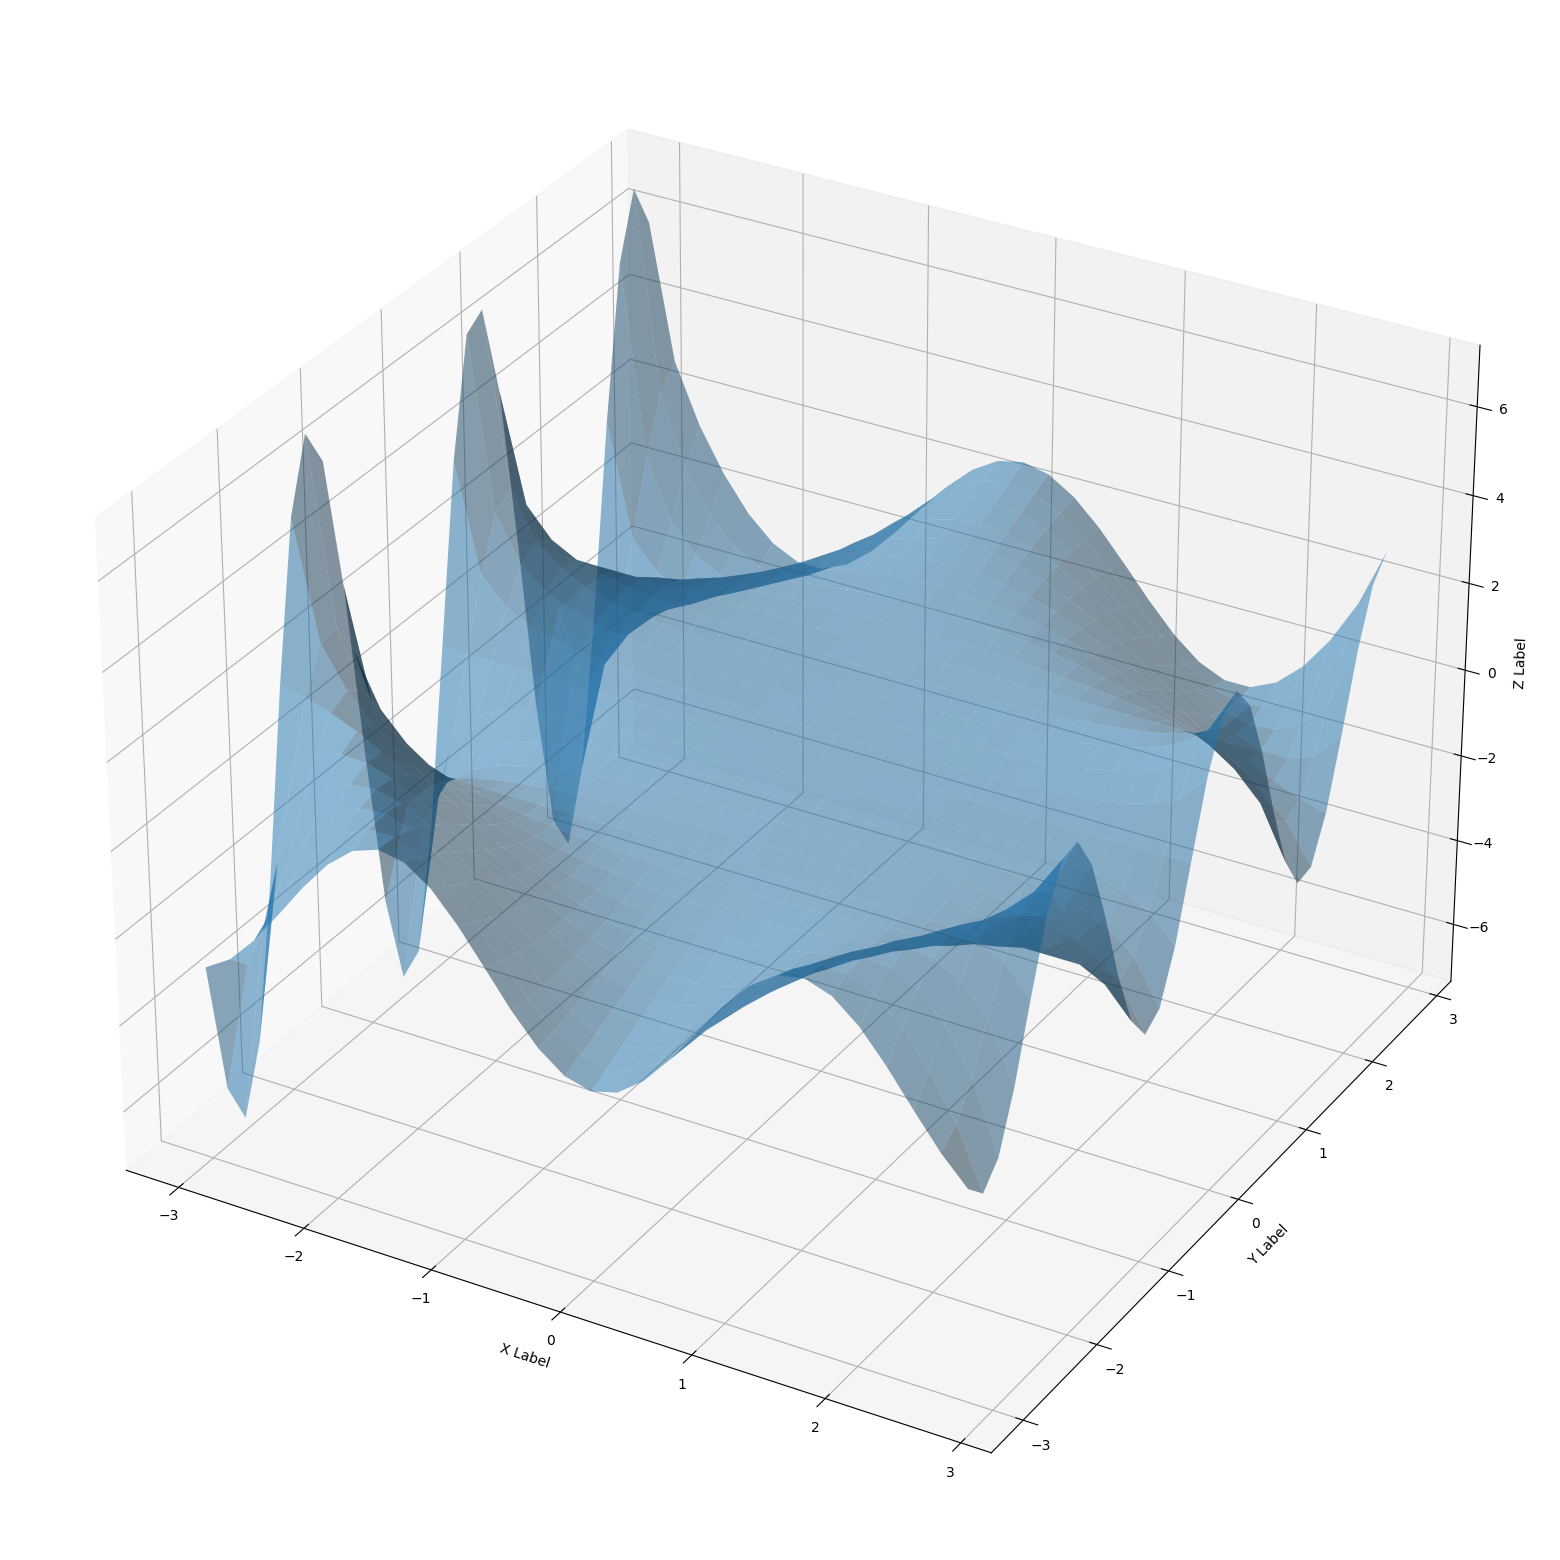

In [ ]:
#from: https://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function

def fun(x, y):
    return math.sin(x*y)/math.sin(x)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3, 3, 0.2)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Building a custom train and test sets


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

dataset_size = 3000
training_size = 1000
domain_dimensionality = 2

data_uniform = torch.rand((dataset_size, domain_dimensionality))
data_domain = data_uniform * 6.0 - 3.0

function_values = torch.sin(data_domain[:, 0] * data_domain[:, 1]) / torch.sin(data_domain[:, 0])

### Visualizing the sample data

We will visualise

- **training set** consisting of 1000 samples as **red** dots.

- **the testing set** consisting of 2000 samples as **black** dots.

The dots should be distributed uniformly throughout our domain.

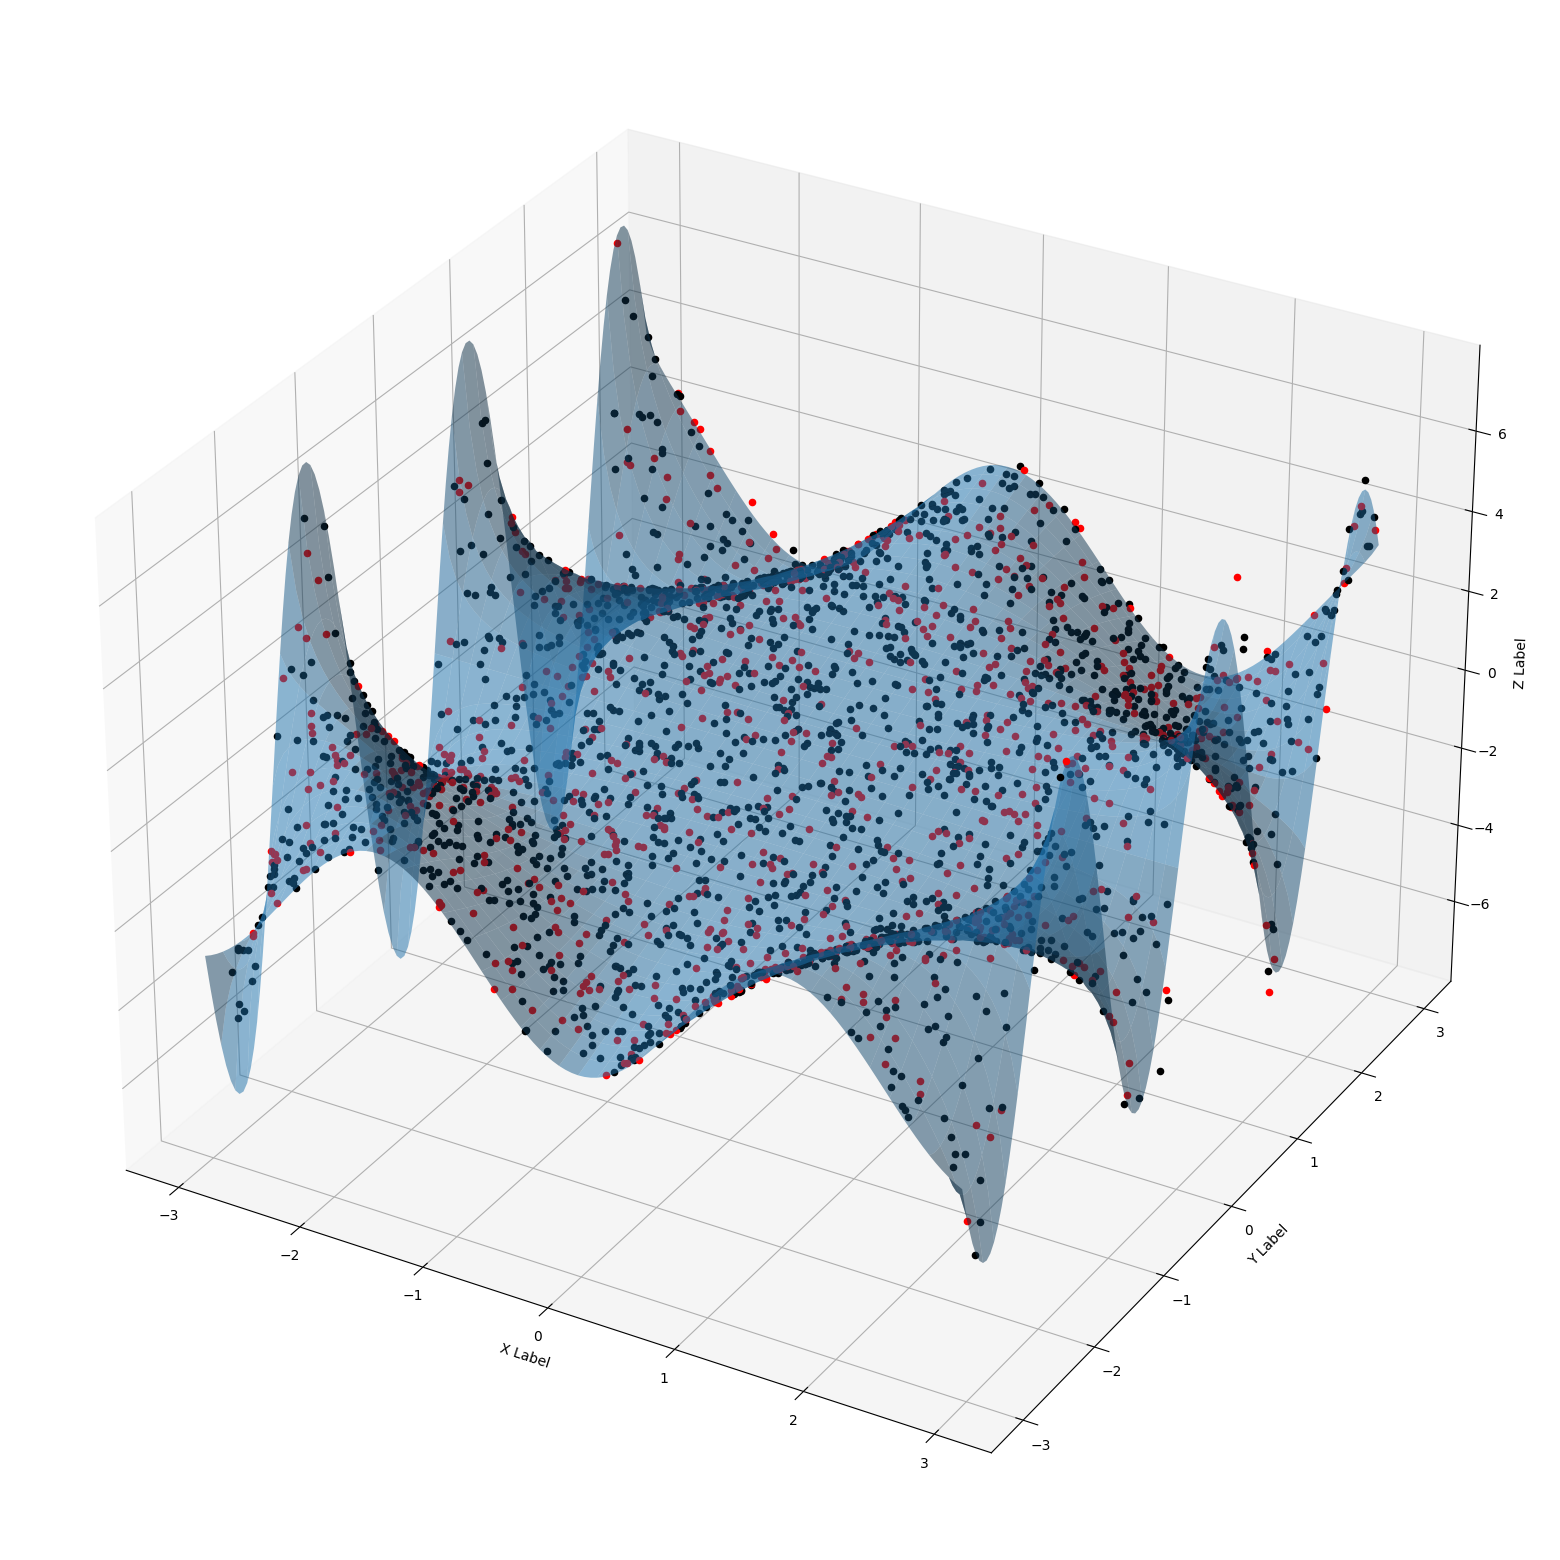

In [ ]:
#from: https://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function

def fun(x, y):
    return math.sin(x*y)/math.sin(x)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3, 3, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for i in range(training_size):    #   training set
  ax.scatter3D(data_domain[i, 0], data_domain[i, 1], function_values[i], color="red")

for i in range(training_size, dataset_size):     #   testing set
  ax.scatter3D(data_domain[i, 0], data_domain[i, 1], function_values[i], color="black")

plt.show()

### Wrapping the dataset: the train and test **datasets** and **loaders**

It is rather a technical detail but typically in PyTorch we work with data loaders. They provide batching, subsampling and some other convenient
functions for us automatically.

We need two separate data loaders: one for a training and one for a testing set.

In [ ]:
# binding input with output into a Data Set

train_set = torch.utils.data.TensorDataset(data_domain[0:training_size, :], function_values[0:training_size])
test_set  = torch.utils.data.TensorDataset(data_domain[training_size:dataset_size, :], function_values[training_size:dataset_size])

# Wrapping the Data Set into a Data Loader

trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)


Let us visualise the training labels

In [ ]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([-1.0210, -1.1473, -1.7258, -0.3091, -0.1987,  0.4183, -0.4461,  1.6088,
        -1.7454, -0.9166, -0.5250,  0.5356,  0.8001, -0.5465,  1.0078, -1.9357,
         0.8675, -1.3167, -1.8778, -0.5843,  0.4938,  1.2742,  0.9802,  1.1281,
        -0.6218,  6.1277,  0.8408,  0.3456, -0.7478,  2.1963,  1.3368, -1.2079,
        -0.9197,  0.3332, -2.0494,  1.0399,  0.9731, -2.1869, -1.0947, -0.8207,
         0.4154,  1.4866,  1.2580, -1.2283,  1.4020, -0.8110,  1.0201, -1.7007,
         3.8113,  2.3414,  0.3648,  0.7613,  0.1074, -0.1389, -1.3024,  0.1539,
         0.9007,  1.9196, -1.8583, -1.0767, -0.3692,  3.1590,  1.0022,  1.9886,
        -0.9657,  2.2096, -1.0774,  0.4504,  0.9314, -1.3121,  0.7884,  3.5386,
         1.4043, -0.8933, -0.2806,  0.1783, -0.5793,  2.4727, -0.3682,  2.3502,
         1.3755,  0.1351, -0.8567,  0.8107,  0.9548, -1.8222,  1.2562, -0.9832,
         0.0096, -0.9197,  1.0118,  0.1427, -0.5284,  1.5667,  1.9434,  0.1139,
         0.9622, -0


### Your taks #2

A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

Your task is to visualise and inspect the number of orders in data in batch_inputs.

In [ ]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[ 0.9503,  0.1308],
        [ 1.8564,  0.7996],
        [-0.0938,  1.3474],
        [-2.5175,  0.3802],
        [-2.0205,  2.0193],
        [ 0.2879,  2.2401],
        [-0.7750, -1.8177],
        [-0.6521,  1.1148],
        [-1.4975, -1.4448],
        [ 0.9820, -2.9708],
        [-0.4050,  0.4405],
        [ 0.8413,  1.4727],
        [-1.6324,  1.7186],
        [-0.2986, -0.9059],
        [-0.5427, -0.5706],
        [ 1.2036,  0.7575],
        [ 0.9508,  0.2164],
        [-1.6712, -1.1200],
        [-0.4049, -0.8526],
        [-1.2221, -1.0796],
        [-2.8117,  2.2216],
        [-1.0225,  0.9099],
        [ 1.4399,  2.4706],
        [-1.3677,  1.1187],
        [ 2.0209,  0.7577],
        [-1.8958,  2.9178],
        [-1.3439, -2.0054],
        [-0.9641, -0.6352],
        [ 1.3708,  2.2532],
        [-0.9908,  0.3166],
        [-1.9161, -0.7374],
        [-0.8861,  0.4895],
        [-0.9205,  0.4519],
        [ 2.3150,  0.9808],
        [ 1.8974,  2.9043],

OK, so each data point was initially a two dimensional point (== a vector == a tensor of order 1) so the batches of them have order 2. So far, so good.

### Defining a Multi Layer Percetron network

Now, a definition of a simple MLP network.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   # Sequential is a structure which allows stacking layers one on another in such a way,
                                          # that output from a preceding layer serves as input to the next layer

            torch.nn.Linear(2, 64),  # INPUT to the first Linear layer is a two dimensional tensor on the last order
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),   # IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU(),             # ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(16, 1),
        )
        self.dropout = torch.nn.Dropout(0.01)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

### Training

Training consists of
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- running through multiple epochs and updating the network weights

In [ ]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   # initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        # different choices are possible, but this is outside the scope of this workshop

net.train()    # it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   # this line calls the forward(self, x) method of the MLP object.

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       # this computes gradients as we have seen in previous workshops
        optimizer.step()     # but this line in fact updates our neural network.
                                #### You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 1.8070164918899536
epoch: 0 batch: 1 current batch loss: 1.2920334339141846
epoch: 0 batch: 2 current batch loss: 2.5392889976501465
epoch: 0 batch: 3 current batch loss: 2.36867356300354
epoch: 0 batch: 4 current batch loss: 2.0588512420654297
epoch: 0 batch: 5 current batch loss: 1.8713316917419434
epoch: 0 batch: 6 current batch loss: 1.8251070976257324
epoch: 0 batch: 7 current batch loss: 1.452017068862915
epoch: 1 batch: 0 current batch loss: 2.1499462127685547
epoch: 1 batch: 1 current batch loss: 1.8440470695495605
epoch: 1 batch: 2 current batch loss: 2.119612216949463
epoch: 1 batch: 3 current batch loss: 1.9448695182800293
epoch: 1 batch: 4 current batch loss: 1.9374881982803345
epoch: 1 batch: 5 current batch loss: 1.5872198343276978
epoch: 1 batch: 6 current batch loss: 1.865600824356079
epoch: 1 batch: 7 current batch loss: 1.6727912425994873
epoch: 2 batch: 0 current batch loss: 1.6182446479797363
epoch: 2 batch: 1 current batch loss

<ipython-input-42-aa310e2e0ff8>:16: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")
<ipython-input-42-aa310e2e0ff8>:16: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")


epoch: 3 batch: 5 current batch loss: 2.0660128593444824
epoch: 3 batch: 6 current batch loss: 1.5881129503250122
epoch: 3 batch: 7 current batch loss: 1.3806990385055542
epoch: 4 batch: 0 current batch loss: 1.9145539999008179
epoch: 4 batch: 1 current batch loss: 1.830599069595337
epoch: 4 batch: 2 current batch loss: 2.5212206840515137
epoch: 4 batch: 3 current batch loss: 1.8224108219146729
epoch: 4 batch: 4 current batch loss: 1.6588044166564941
epoch: 4 batch: 5 current batch loss: 1.531179428100586
epoch: 4 batch: 6 current batch loss: 2.288832664489746
epoch: 4 batch: 7 current batch loss: 1.4990479946136475
epoch: 5 batch: 0 current batch loss: 2.2945947647094727
epoch: 5 batch: 1 current batch loss: 1.9454180002212524
epoch: 5 batch: 2 current batch loss: 2.27016282081604
epoch: 5 batch: 3 current batch loss: 2.2118313312530518
epoch: 5 batch: 4 current batch loss: 1.5337681770324707
epoch: 5 batch: 5 current batch loss: 1.4258909225463867
epoch: 5 batch: 6 current batch loss

### Your task #3

You need to repair this code. Understand what is a problem signaled with the warning.

### Solution

Have a look at the warning.

From the warning we infer that there is a problem with the calculation of the loss value. Concretely, the sizes of the two tensors seem not to match. Let's inspect the sizes:

In [ ]:

for epoch in range(1):  #  only one epoch

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   # this line calls the forward(self, x) method of the MLP object.

        print(batch_outputs.size())
        print(batch_labels.size())



torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([104, 1])
torch.Size([104])


That's true. The network output is a batched vector, not a batched single value. In other words, it has one additional order, which is not needed. We need to remove it **before** we call the loss calculation:

In [ ]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    # it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(500):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   # this line calls the forward(self, x) method of the MLP object.

        # SOLUTION HERE ############################ remove the last - unwanted - tensor order
        batch_outputs = batch_outputs.squeeze(1)

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       # this computes gradients as we have seen in previous workshops
        optimizer.step()     # but this line in fact updates our neural network.
                                #### You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 2.6560211181640625
epoch: 0 batch: 1 current batch loss: 2.363489866256714
epoch: 0 batch: 2 current batch loss: 1.6057881116867065
epoch: 0 batch: 3 current batch loss: 1.4578619003295898
epoch: 0 batch: 4 current batch loss: 1.8680593967437744
epoch: 0 batch: 5 current batch loss: 1.9789676666259766
epoch: 0 batch: 6 current batch loss: 1.5671257972717285
epoch: 0 batch: 7 current batch loss: 1.9624639749526978
epoch: 1 batch: 0 current batch loss: 1.9117863178253174
epoch: 1 batch: 1 current batch loss: 1.9934130907058716
epoch: 1 batch: 2 current batch loss: 1.3672857284545898
epoch: 1 batch: 3 current batch loss: 2.208728313446045
epoch: 1 batch: 4 current batch loss: 2.612647294998169
epoch: 1 batch: 5 current batch loss: 1.866654396057129
epoch: 1 batch: 6 current batch loss: 1.6739434003829956
epoch: 1 batch: 7 current batch loss: 1.1192330121994019
epoch: 2 batch: 0 current batch loss: 1.6661895513534546
epoch: 2 batch: 1 current batch los

### Your task #4

Redefine the network. Add two more layers changing the dimensionality to 1024 and back. See if it helps with the loss.

Maybe now 200 epochs will suffice to bring the loss below 0.1?

### Solution

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer

            torch.nn.Linear(2, 64),  # INPUT to the first Linear layer is a two dimensional tensor on the last order
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(16, 1),
        )
        self.dropout = torch.nn.Dropout(0.01)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(200):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object.

        # remove the last - unwanted - tensor order
        batch_outputs = batch_outputs.squeeze(1)

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 1.805615782737732
epoch: 0 batch: 1 current batch loss: 1.987716555595398
epoch: 0 batch: 2 current batch loss: 1.9484081268310547
epoch: 0 batch: 3 current batch loss: 1.7976117134094238
epoch: 0 batch: 4 current batch loss: 1.5138506889343262
epoch: 0 batch: 5 current batch loss: 2.0360517501831055
epoch: 0 batch: 6 current batch loss: 1.7343025207519531
epoch: 0 batch: 7 current batch loss: 1.2982299327850342
epoch: 1 batch: 0 current batch loss: 1.2856158018112183
epoch: 1 batch: 1 current batch loss: 1.8465176820755005
epoch: 1 batch: 2 current batch loss: 1.3245227336883545
epoch: 1 batch: 3 current batch loss: 1.7247847318649292
epoch: 1 batch: 4 current batch loss: 1.8998475074768066
epoch: 1 batch: 5 current batch loss: 1.8146240711212158
epoch: 1 batch: 6 current batch loss: 1.5434483289718628
epoch: 1 batch: 7 current batch loss: 1.4828972816467285
epoch: 2 batch: 0 current batch loss: 1.6425352096557617
epoch: 2 batch: 1 current batch l


### Your task #5

Comment the line `optimizer.step()` above. Change the number of epochs to 2.Rerun the above code. Note that the loss is NOT constant as the comment in the code seems to promise, but anyway, the loss doesn't improve, either. Please explain, why the loss is not constant. Please explain, why the loss doesn't improve, either.

An epoch is a one full passage through the whole training data. Why then, on the second epoch, the losses are different than in the first epoch?

### Answers to task #5

The loss is not constant because in our code we are printing losses in batches, and each batch is a different data sample. A loss value calculated on different data sample may be different. Moreover, the second epoch and subsequent epochs, i.e. next runs through the whole data, they consist of different randomly shuffled batches, because we selected `shuffle = True` when initiating a training dataset. It means, that even in next epochs, batched samples will be different samples and the loss values may differ.

But overall, loss desn't improve because the weights in the network do not change. The line responsible for changing the weights in the network is commented.

### Training - the second approach


Sometimes during training loss stabilizes and doesn't improve anymore. It is not the case here (yet, but we have only run 8 epochs), but a real problem in practice.
We can include a new tool called a **scheduler** that would update the *learning rate* in an otpimizer after each epoch. This usually helps the training. Let us reformulate the traning so it consists of
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- a definition of a scheduler to update the learning rate in an optimizer
- running through multiple epochs and updating the network weights

In [ ]:
net_with_scheduler = MLP()
optimizer = torch.optim.Adam(net_with_scheduler.parameters(), 0.001)   #initial learning rate of 0.001.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)    #updates the learning rate after each epoch. There are many ways to do that: StepLR multiplies learning rate by gamma


net_with_scheduler.train()    # it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(200):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net_with_scheduler(batch_inputs)   # this line calls the forward(self, x) method of the MLP object.

        # remove the last - unwanted - tensor order
        batch_outputs = batch_outputs.squeeze(1)

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item(), "current lr:", scheduler.get_last_lr()[0])
        loss.backward()       # this computes gradients as we have seen in previous workshops
        optimizer.step()     # but this line in fact updates our neural network.
                                #### You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update

    scheduler.step()

epoch: 0 batch: 0 current batch loss: 2.2815184593200684 current lr: 0.001
epoch: 0 batch: 1 current batch loss: 1.7075908184051514 current lr: 0.001
epoch: 0 batch: 2 current batch loss: 1.844173789024353 current lr: 0.001
epoch: 0 batch: 3 current batch loss: 1.91521418094635 current lr: 0.001
epoch: 0 batch: 4 current batch loss: 1.609473705291748 current lr: 0.001
epoch: 0 batch: 5 current batch loss: 2.1493546962738037 current lr: 0.001
epoch: 0 batch: 6 current batch loss: 1.8404786586761475 current lr: 0.001
epoch: 0 batch: 7 current batch loss: 1.3052866458892822 current lr: 0.001
epoch: 1 batch: 0 current batch loss: 2.1729328632354736 current lr: 0.000999
epoch: 1 batch: 1 current batch loss: 1.471026062965393 current lr: 0.000999
epoch: 1 batch: 2 current batch loss: 1.7762866020202637 current lr: 0.000999
epoch: 1 batch: 3 current batch loss: 1.517258644104004 current lr: 0.000999
epoch: 1 batch: 4 current batch loss: 1.5252375602722168 current lr: 0.000999
epoch: 1 batch: 


### Your task #6

The scheduler didn't help much. Maybe the proposed gamma was to low or to high(it was 0.999)? Please experiment with different settings for the optimizer learning rate and different scheduler settings. There are other schedulers you can experiment with, too. Please verify what would happen if the nets were allowed to train for more training epochs.

**Some other schedulers you might want to experiment with:**
- Exponential LR - decays the learning rate of each parameter group by gamma every epoch - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)
- Step LR - more general then the Exponential LR: decays the learning rate of each parameter group by gamma every step_size epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)
- Cosine Annealing LR - learning rate follows the first quarter of the cosine curve - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
- Cosine with Warm Restarts - learning rate follows the first quarter of the cosine curve and restarts after a predefined number of epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html)


### Your task #7

Please explain, what are the dangers of bringing the loss too low? What is an *overtrained* neural network? How can one prevent it?

### Testing

Now we will test those two nets - the one without and the one with the scheduler.

In [ ]:
sum_of_squares = 0.0
count = 0
network_predictions = np.zeros(dataset_size - training_size)

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, y = data

        y_hat = net(datapoint)
        # storing the predictions for future use
        network_predictions[count] = y_hat


        sum_of_squares += (y.item() - y_hat.item()) ** 2
        count += 1

print("total sum of squares error = ", sum_of_squares)
print("mean square error (MSE) = ", sum_of_squares / count)
print("root mean square error (RMSE) = ", (sum_of_squares / count) ** 0.5)

total sum of squares error =  95.04284697137759
mean square error (MSE) =  0.047521423485688795
root mean square error (RMSE) =  0.2179940904834092


In [ ]:
sum_of_squares = 0.0
count = 0
net_with_scheduler.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation

with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, y = data

        y_hat = net_with_scheduler(datapoint)

        sum_of_squares += (y.item() - y_hat.item()) ** 2
        count += 1

print("total sum of squares error = ", sum_of_squares)
print("mean square error (MSE) = ", sum_of_squares / count)
print("root mean square error (RMSE) = ", (sum_of_squares / count) ** 0.5)

total sum of squares error =  164.53168466519378
mean square error (MSE) =  0.08226584233259689
root mean square error (RMSE) =  0.286820226505379


### Visualising the results

Let's try to plot both the true ground values and the network predictions

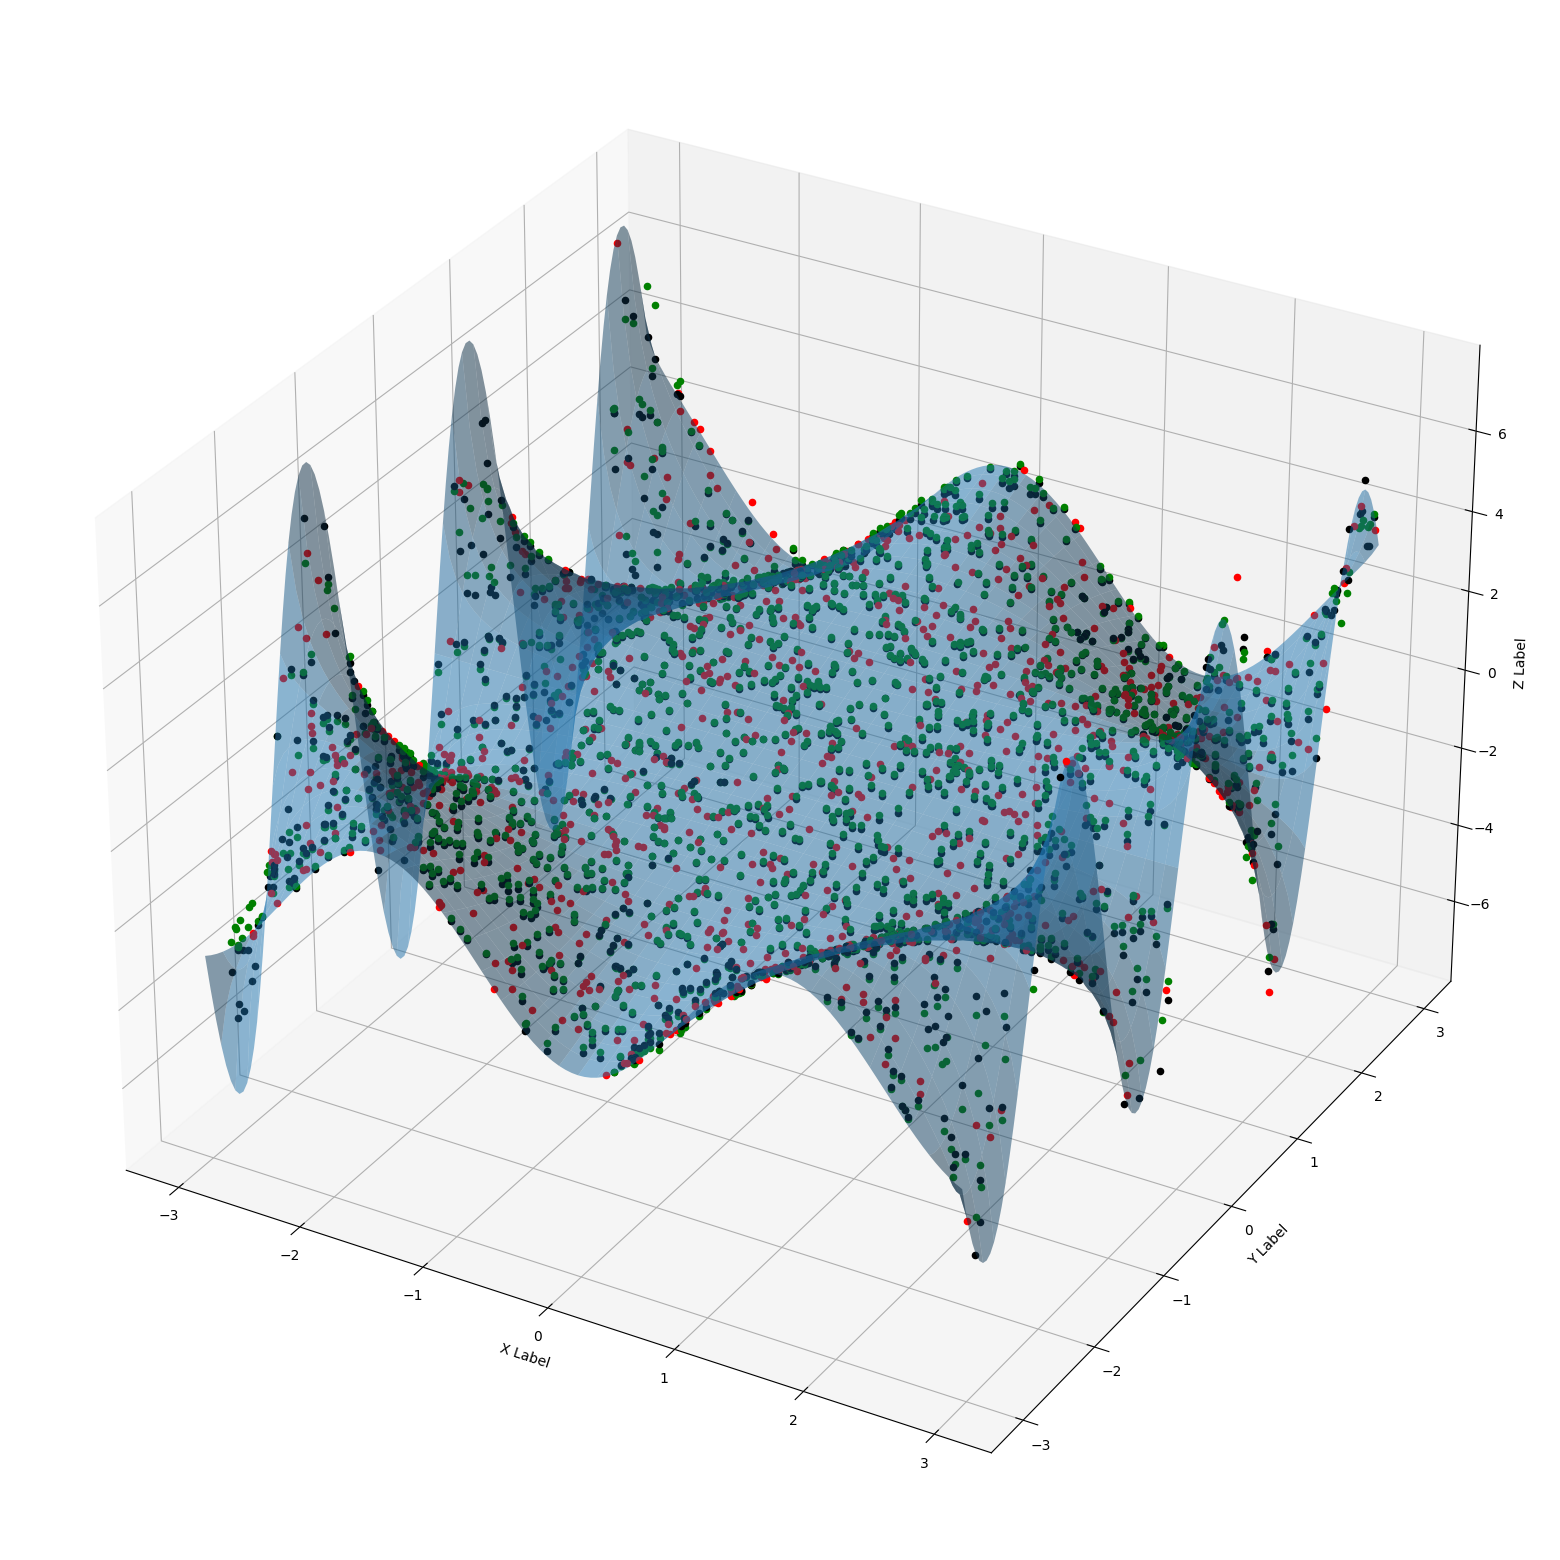

In [ ]:
#from: https://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function

def fun(x, y):
    return math.sin(x*y)/math.sin(x)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3, 3, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for i in range(training_size):     #   training set
  ax.scatter3D(data_domain[i, 0], data_domain[i, 1], function_values[i], color="red")

for i in range(training_size, dataset_size):     #   testing set
  ax.scatter3D(data_domain[i, 0], data_domain[i, 1], function_values[i], color="black")

for i in range(training_size, dataset_size):     #   prediction
  ax.scatter3D(data_domain[i, 0], data_domain[i, 1], network_predictions[i - training_size], color="green")


plt.show()




# Moving computations to GPU

In the code above we didn't move the computations to GPU. The first task is moving the computations to GPU. How do you do that?

Ability to compute on GPU is called CUDA:  Compute Unified Device Architecture.

First, we check if CUDA is available:

In [ ]:
torch.cuda.is_available()

True

How to make CUDA available if it is not?

* On a local machine you must connect and properly configure a GPU card, it is out of scope of this workshop.

* In Google Colab online, you click `Runtime` > `Change runtime` and change `Hardware acceleration` setting to `GPU`.

* In Google Colab **Polish version**, you click `Środowisko wykonawcze` > `Zmień typ środowiska wykonawczego` and change `Akcelerator sprzętowy` setting to `GPU`.

Once we have CUDA (or not: this case should be handled in the code, too), we are ready to determine the computation device. Note that it is just a character string:


In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(device)

cuda


Then we move our neural network model and each tensor with batch data to GPU. We can do it by passing the `device = device` argument during the model or tensor construction, or by calling a `to(device)` method on a model or a tensor:

In [ ]:
layer = torch.nn.Linear(2048, 256, device = device)
layer = torch.nn.Linear(2048, 256).to(device)

### Your task #8

Enable CUDA computations in all the code above:

1. Check if CUDA is available before the MLP definition
2. Add the device field to the constructor and pass it to all constructed layers
3. Add the device argument when constructing MLP
4. Add the device arguments to all tensors that get passed to MLP

In [ ]:
########################################### check  if CUDA available #################################################
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

########################################### MLP definition on GPU #################################################
class MLP(torch.nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer

            torch.nn.Linear(2, 64, device = device),  # the device gets passed here

            torch.nn.ReLU(),                          # ReLU is just a function with no parameters stored on GPU nor on CPU - it doesn't need to be on GPU
            torch.nn.Linear(64, 128, device = device),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1024, device = device),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128, device = device),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16, device = device),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1, device = device),
        )
        self.dropout = torch.nn.Dropout(0.01)         # Dropout is just a function with no parameters stored on GPU nor on CPU - it doesn't need to be on GPU

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x


################################################ TRAINING ON GPU ####################################################################
net = MLP(device)                                    # put the network on a GPU
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(200):

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs.to(device))   # move the input batch to GPU before it gets passed to a network
                                                       # the outputs are on the GPU too

        batch_labels = batch_labels.to(device)         # move the ground truth labels to GPU before it gets compared to a network output

        # remove the last - unwanted - tensor order
        batch_outputs = batch_outputs.squeeze(1)

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()
        optimizer.step()

epoch: 0 batch: 0 current batch loss: 1.7912726402282715
epoch: 0 batch: 1 current batch loss: 1.5417908430099487
epoch: 0 batch: 2 current batch loss: 2.3260066509246826
epoch: 0 batch: 3 current batch loss: 1.9106065034866333
epoch: 0 batch: 4 current batch loss: 1.6209113597869873
epoch: 0 batch: 5 current batch loss: 1.4248769283294678
epoch: 0 batch: 6 current batch loss: 1.4442706108093262
epoch: 0 batch: 7 current batch loss: 2.271533966064453
epoch: 1 batch: 0 current batch loss: 2.199315309524536
epoch: 1 batch: 1 current batch loss: 1.9214439392089844
epoch: 1 batch: 2 current batch loss: 1.4780235290527344
epoch: 1 batch: 3 current batch loss: 1.6030128002166748
epoch: 1 batch: 4 current batch loss: 1.9616644382476807
epoch: 1 batch: 5 current batch loss: 1.0064040422439575
epoch: 1 batch: 6 current batch loss: 1.827880620956421
epoch: 1 batch: 7 current batch loss: 1.4399698972702026
epoch: 2 batch: 0 current batch loss: 1.3161978721618652
epoch: 2 batch: 1 current batch lo

In [ ]:
################################################ TESTING ON GPU #####################################################
sum_of_squares = 0.0
count = 0

net.eval()
with torch.no_grad():
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, y = data

        y_hat = net(datapoint.to(device))    # moving a batch to GPU

        sum_of_squares += (y.item() - y_hat.item()) ** 2   # the comparison is on item() which is not a tensor, i.e. there is no need to move labels to GPU
        count += 1

print("total sum of squares error = ", sum_of_squares)
print("mean square error (MSE) = ", sum_of_squares / count)
print("root mean square error (RMSE) = ", (sum_of_squares / count) ** 0.5)

total sum of squares error =  102.14747371369202
mean square error (MSE) =  0.05107373685684601
root mean square error (RMSE) =  0.2259949929906546


## Desequencing forward computations

In the MLP definition above we used a sequential layer. In order to demonstrate how in general one can perform arbitrary forward computations, we will remove the sequential layer now.

### Your task #9

Remove the sequential layer

1. Remove the sequential layer by using separate variables for the layers within.
2. Change the forward flow to pass `x` through all layers.

In [ ]:

########################################### MLP definition without sequential #################################################
class MLP(torch.nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(2, 64, device = device)  # the device gets passed here
        self.linear2 = torch.nn.Linear(64, 128, device = device)
        self.linear3 = torch.nn.Linear(128, 1024, device = device)
        self.linear4 = torch.nn.Linear(1024, 128, device = device)
        self.linear5 = torch.nn.Linear(128, 16, device = device)
        self.linear6 = torch.nn.Linear(16, 1, device = device)

        self.relu = torch.nn.ReLU()    #only one of those is needed in the current setup

        self.linear_res = torch.nn.Linear(1024, 1024, device = device)     # a layer not changing shape of input, it will be used as an example of residual skip connection layer

    def forward(self, x):
        x = self.linear1(x)  # we pass x sequentially through all layers and nonlinearities in our network
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = x ** 2 + self.linear_res(x)   # an example of residual skip connections, usually one skips layers with x, not x^2,
                                         # but this layer is linear and I wanted to accentuate the example you can code the forward pass completely freely
        x = self.relu(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.linear5(x)
        x = self.relu(x)
        x = self.linear6(x)
        return x

########################################### TRAINING #################################################
net = MLP(device)                                    # put the network on a GPU
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(200):

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs.to(device))   # move the input batch to GPU before it gets passed to a network
                                                       # the outputs are on the GPU too

        batch_labels = batch_labels.to(device)        # move the ground truth labels to GPU before it gets compared to a network output

        # remove the last - unwanted - tensor order
        batch_outputs = batch_outputs.squeeze(1)

        loss = torch.nn.functional.mse_loss(batch_outputs, batch_labels, reduction = "mean")

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       # this computes gradients as we have seen in previous workshops
        optimizer.step()      # but this line in fact updates our neural network.


epoch: 0 batch: 0 current batch loss: 1.4858624935150146
epoch: 0 batch: 1 current batch loss: 2.2283682823181152
epoch: 0 batch: 2 current batch loss: 2.0002875328063965
epoch: 0 batch: 3 current batch loss: 1.0184999704360962
epoch: 0 batch: 4 current batch loss: 1.8794646263122559
epoch: 0 batch: 5 current batch loss: 1.4737114906311035
epoch: 0 batch: 6 current batch loss: 1.7845892906188965
epoch: 0 batch: 7 current batch loss: 2.436939239501953
epoch: 1 batch: 0 current batch loss: 1.7439918518066406
epoch: 1 batch: 1 current batch loss: 1.2402535676956177
epoch: 1 batch: 2 current batch loss: 1.891844630241394
epoch: 1 batch: 3 current batch loss: 1.2839770317077637
epoch: 1 batch: 4 current batch loss: 2.2145237922668457
epoch: 1 batch: 5 current batch loss: 2.2795560359954834
epoch: 1 batch: 6 current batch loss: 1.8493907451629639
epoch: 1 batch: 7 current batch loss: 0.9684285521507263
epoch: 2 batch: 0 current batch loss: 2.0737926959991455
epoch: 2 batch: 1 current batch l

In [ ]:
################################################ TESTING #####################################################
sum_of_squares = 0.0
count = 0

net.eval()
with torch.no_grad():
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, y = data

        y_hat = net(datapoint.to(device))    # moving a batch to GPU

        sum_of_squares += (y.item() - y_hat.item()) ** 2   # the comparison is on item() which is not a tensor, i.e. there is no need to move labels to GPU
        count += 1

print("total sum of squares error = ", sum_of_squares)
print("mean square error (MSE) = ", sum_of_squares / count)
print("root mean square error (RMSE) = ", (sum_of_squares / count) ** 0.5)

total sum of squares error =  181.25456732330628
mean square error (MSE) =  0.09062728366165314
root mean square error (RMSE) =  0.30104365740146916


# Phase 3 What next

First and foremost - **save your updated Colab notebook into GDrive**, so you can work with it later.

Then - experiment yourself. Try to add a scheduler into LeNet training. Observe that in the final epochs the loss didn't improve much and that the final accuracy was very mediocre. It should supercede than of the MLP network!

There are also aspects of ML we didn't even touch:

1. Validation on an additional validation set, or cross-validation
2. Initializing the network
3. Choice of a scheduler (we used exclusively Adam)
4. Choice of a batch size and accompanying learning rate
5. Choice of a specific loss function for very specific tasks

Those concepts constitute a broad and separate subject, each of them. Explore them and have fun!